## Conformal Prediction Inference

This notebook demonstrates inference using ONNX serialized Conformal Prediction models.

### Imports

In [1]:
import joblib
import numpy as np
import onnxruntime as rt

### Load Data

In [2]:
x_test_single_point, y_test_single_point = joblib.load('input_data.joblib')
x_test, y_test = joblib.load('batch_input_data.joblib')

### Load ONNX Models

#### Single Region Model

In [3]:
with open('single_region_cp_model.onnx', 'rb') as fp:
    single_region_cp_model_bytes = fp.read()

single_region_sess = rt.InferenceSession(single_region_cp_model_bytes)

#### Multi Region Model

In [4]:
with open('multi_region_cp_model.onnx', 'rb') as fp:
    multi_region_cp_model_bytes = fp.read()

multi_region_sess = rt.InferenceSession(multi_region_cp_model_bytes)

### Inference

In [5]:
single_output = single_region_sess.run(None, {"X": x_test_single_point})
for i, out in enumerate(single_region_sess.get_outputs()):
    print({out.name: single_output[i]})

{'prediction': array([[[2.4208233]]], dtype=float32)}
{'exp_lower_pred_endpoint': array([[[-2.4448354]]], dtype=float32)}
{'exp_upper_pred_endpoint': array([[[7.286482]]], dtype=float32)}


In [6]:
multi_output = multi_region_sess.run(None, {"X": x_test_single_point})
for i, out in enumerate(multi_region_sess.get_outputs()):
    print({out.name: multi_output[i]})

{'input_x': array([[0.23750836]], dtype=float32)}
{'prediction': array([[2.4208233]], dtype=float32)}
{'region_model_prediction': array([[6.377759]], dtype=float32)}
{'exp_lower_pred_endpoint': array([[-4.5900803]], dtype=float32)}
{'exp_upper_pred_endpoint': array([[9.431727]], dtype=float32)}


### Single vs Multi Region Comparison

In [7]:
x_test_sort_indices = np.argsort(x_test.flatten())
single_region_model_onnx_output = single_region_sess.run(None, {"X": x_test[x_test_sort_indices].astype(np.float32)})
multi_region_model_onnx_output = multi_region_sess.run(None, {"X": x_test[x_test_sort_indices].astype(np.float32)})

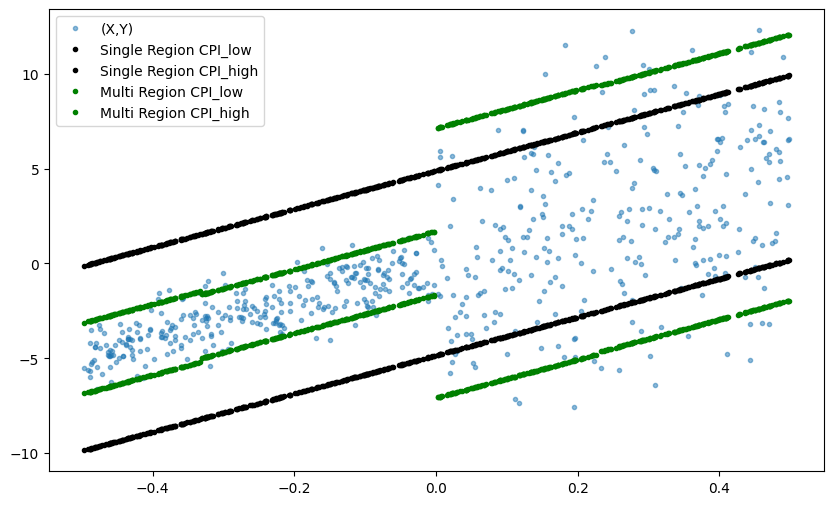

In [8]:
import matplotlib.pyplot as plt

x_test_sort = np.sort(x_test.flatten())
x_test_sort_indices = np.argsort(x_test.flatten())


plt.rcParams["figure.figsize"] = (10, 6)

plt.plot(x_test_sort, y_test[x_test_sort_indices], '.', alpha = 0.5, label='(X,Y)')
plt.plot(x_test_sort, single_region_model_onnx_output[-2][:, 0], 'k.', label = 'Single Region CPI_low')
plt.plot(x_test_sort, single_region_model_onnx_output[-1][:, 0], 'k.', label = 'Single Region CPI_high')

plt.plot(x_test_sort, multi_region_model_onnx_output[-2][:, 0], 'g.', label = 'Multi Region CPI_low')
plt.plot(x_test_sort, multi_region_model_onnx_output[-1][:, 0], 'g.', label = 'Multi Region CPI_high')

plt.legend(loc='upper left', bbox_to_anchor=(0, 1.0))
plt.show()